# Chapter04 모델 훈련

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

### 4.1 선형 회귀

선형회귀 모델의 예측 ( $\hat{y}$ )

$\hat{y} = h_\theta(x) = \theta \space \cdot x = \theta^T \cdot x$

- $\theta$ : 가중치

- $x$ : 특성

$MSE(X, h_\theta) = \frac{1}{m} \Sigma^m_{i=1} ( \theta^T x^{(i)} - y^{(i)})^2 = \frac{1}{m} \Sigma^m_{i=1} ( X \cdot \hat{\theta} - y^{(i)})^2$

미분 계산 : $\frac{\partial L}{\partial \hat{\theta}}$ = 0 $\space$  (기울기 0)

--> $\hat{\theta} = (X^T X)^{-1} X^T y$ ( **정규 방정식** )

In [2]:
# (선형 데이터셋) 무작위로 생성
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # y = 3x + 4 + (가우시안 잡음)

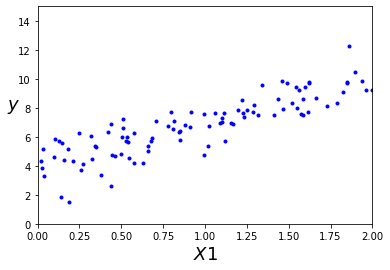

In [3]:
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.xlabel('$X1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.show()

위 정규방정식을 사용하여 $\hat{\theta}$ 를 구해보자

In [4]:
X_b = np.c_[np.ones((100, 1)), X]   # X에 편향계수 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # 정규 방정식
theta_best

array([[3.88641118],
       [3.05877276]])

In [5]:
# theta_best로 예측하기
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # 펀향 계수 추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.88641118],
       [10.0039567 ]])

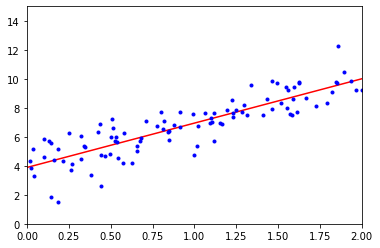

In [6]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# 사이킷런에서의 선형 회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[3.88641118] [[3.05877276]]


array([[ 3.88641118],
       [10.0039567 ]])

In [46]:
# LinearRegression()은 np.linalg.lstsq이 기반이 된다

# residuals: 실제데이터와의 차이
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)   # Least Square
print(theta_best_svd)
print(f'residuals: {residuals}')

[[3.88641118]
 [3.05877276]]
residuals: [101.74044299]


In [47]:
np.linalg.pinv(X_b).dot(y)  # 유사 역행렬 (pseudo inverse)

array([[3.88641118],
       [3.05877276]])

유사역행렬은 **SVD 분해** 기법을 사용하여 계산된다.

- 정규방정식은 $X^T X$ 의 역행렬이 없으면 작동하지 않지만, 유사역행렬은 항상 구할 수 있다.

- SVD 방법의 계산복잡도는 정규방정식보다 4배 가량 더 빠르다.

---

### 4.2 경사 하강법

GD : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것

- 경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다. (특성 스케일링)

$$\theta^{(next \space step)_i} = \theta_{(i)} - \eta \frac{\partial L}{\partial \theta_{(i)}}$$

- 배치 경사 하강법 (BGD)

In [108]:
# 배치 경사하강법 구현

eta = 0.1   # 학습률
n_iterations = 1000  # 반복 수
m = 100     # 샘플 수

theta = np.random.randn(2,1)  # 무작위 초기화
print(f"초기 theta 값: \n{theta}\n")

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
print(f"학습 후 theta 값: \n{theta}")

초기 theta 값: 
[[-0.3139951 ]
 [ 0.31437353]]

학습 후 theta 값: 
[[3.88641118]
 [3.05877276]]


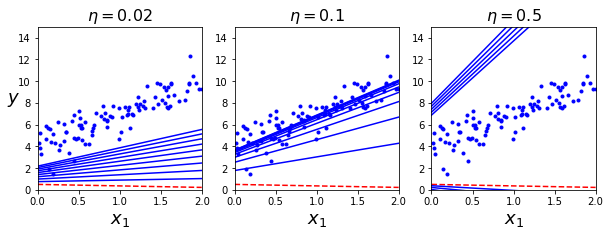

In [71]:
# 학습률에 따른 학습 상태
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,3))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

적절한 학습률을 적용해주어야 학습이 잘된다. --> 그리드 탐색으로 최적의 학습률 찾기

- 확률적 경사 하강법 (SGD)

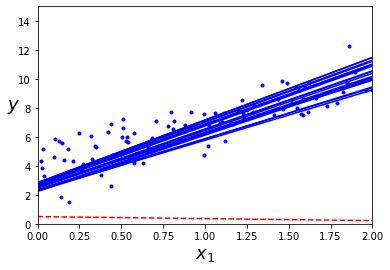

In [183]:
# SGD 구현

theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50   # 에포크
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터
# 학습 스케줄: 매 반복에서 학습률을 결정하는 함수

def learning_schedule(t):   # 학습률을 점진적으로 감소시키는 학습 스케줄
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 무작위로 초기화

for epoch in range(n_epochs):   # 에포크만큼 반복
    for i in range(m):          # 훈련 샘플 수 만큼 반복

        # 첫 에포크일때 스텝 그리기
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)  
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        random_index = np.random.randint(m)     # 랜덤으로
        xi = X_b[random_index:random_index+1]   # 하나씩만 따로 훈련
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

        theta_path_sgd.append(theta)      

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])                   
plt.show()     

In [167]:
from sklearn.linear_model import SGDRegressor

# max_iter: 에포크 횟수
# tol: 한 에포크에서 tol 보다 적게 손실이 줄어들 때까지 실행된다는 의미
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())   # ravel() == flatten()

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [169]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.89613578]), array([3.107683]))

- 미니배치 경사 하강법 (MGD = BGD + SGD)

In [180]:
# 미니배치 경사하강법 구현

theta_path_mgd = []

n_iterations = 50    # 에포크
minibatch_size = 20  # 미니배치 크기

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]   # 미니배치로 사이즈로 묶어서 학습
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta

array([[3.90127139],
       [3.06319431]])

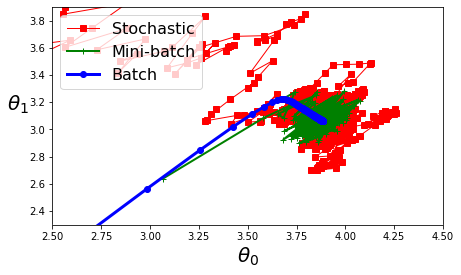

In [184]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

- 미니배치의 크기를 크게 하면 : SGD보다 덜 불규칙적으로 움직이나 local minimum에 빠질 확률이 조금 높아짐

---

### 4.3 다항 회귀

(각 특성의 거듭제곱이라던지) 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

간단한 2차방정식으로 비선형 데이터를 만들어보자

: $y = 0.5x_1^2 + 1.0x_1 + 2.0$

In [220]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X **2 + X + 2 + np.random.randn(m, 1)

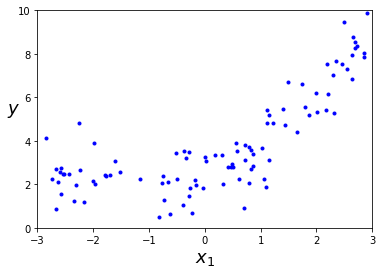

In [221]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [222]:
# 각 특성을 제곱하여 새로운 특성 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.65643835]), array([-0.65643835,  0.43091131]))

In [223]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.35749568]), array([[0.99408314, 0.42635081]]))

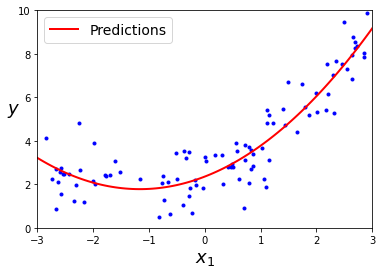

In [224]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

### 4.4 학습 곡선

In [225]:
# 훈련세트의 크기에 따른 학습 곡선

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)  # 검증세트 떼어내기
    train_errors, val_errors = [], []  # 그래프를 그려주기 위한 각 저장공간
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])   # 훈련세트의 크기를 점점 늘려가면서 훈련
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))   # 훈련세트 MSE
        val_errors.append(mean_squared_error(y_val, y_val_predict))             # 검증세트 MSE

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)             

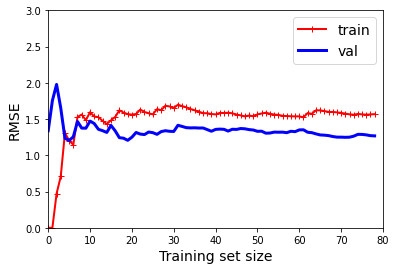

In [226]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])            
plt.show()  

과소적합의 전형적인 모습이다.

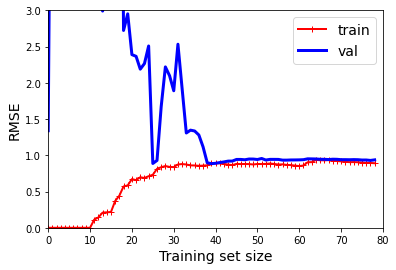

In [235]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
        ('lin_reg', LinearRegression())
    ])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과대적합 모델의 모습

더 많은 훈련 데이터를 추가하는 것이 과대적합을 개선하는 방법 중 하나이다.

---

### 4.5 규제가 있는 선형 모델

과대적합을 감소시키려면 모델에 규제를 가해야 한다.

- 릿지 회귀